In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import itertools

In [2]:
# read in data and parse date column as date type and set it as the index
df = pd.read_csv('/kaggle/input/sarima/train.csv', parse_dates=['date'], index_col='date')

In [3]:
df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [4]:
df.info()
# no missing data aparently

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [5]:
# check duplicates
df.reset_index().duplicated().sum()

0

In [6]:
# check the date range of the data
min_date = df.index.min()
max_date = df.index.max()

print(f"Date Range: {min_date} to {max_date}")

Date Range: 2013-01-01 00:00:00 to 2017-12-31 00:00:00


In [7]:
# check how many stores
df['store'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [8]:
# check how many item
df['item'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [9]:
# lets forecast demand for product 1 in store 1
data = df[(df['store']==1) & (df['item']==1)]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   store   1826 non-null   int64
 1   item    1826 non-null   int64
 2   sales   1826 non-null   int64
dtypes: int64(3)
memory usage: 57.1 KB


In [11]:
data =data.drop(columns=['store','item'])

In [12]:
data.head()

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


In [13]:
#analysis of sales
data.describe()

,sales
count,1826.000000
mean,19.971522
std,6.741022
min,4.000000
25%,15.000000
50%,19.000000
75%,24.000000
max,50.000000


<Axes: >

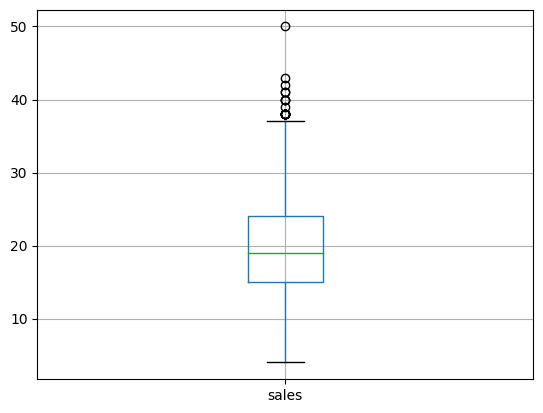

In [14]:
data.boxplot()

array([[<Axes: title={'center': 'sales'}>]], dtype=object)

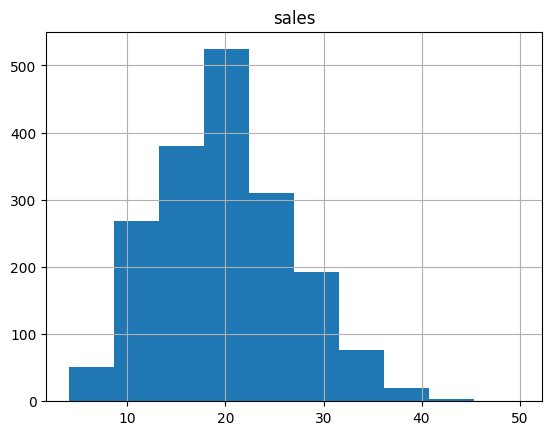

In [15]:
data.hist()

Text(0, 0.5, 'Sales')

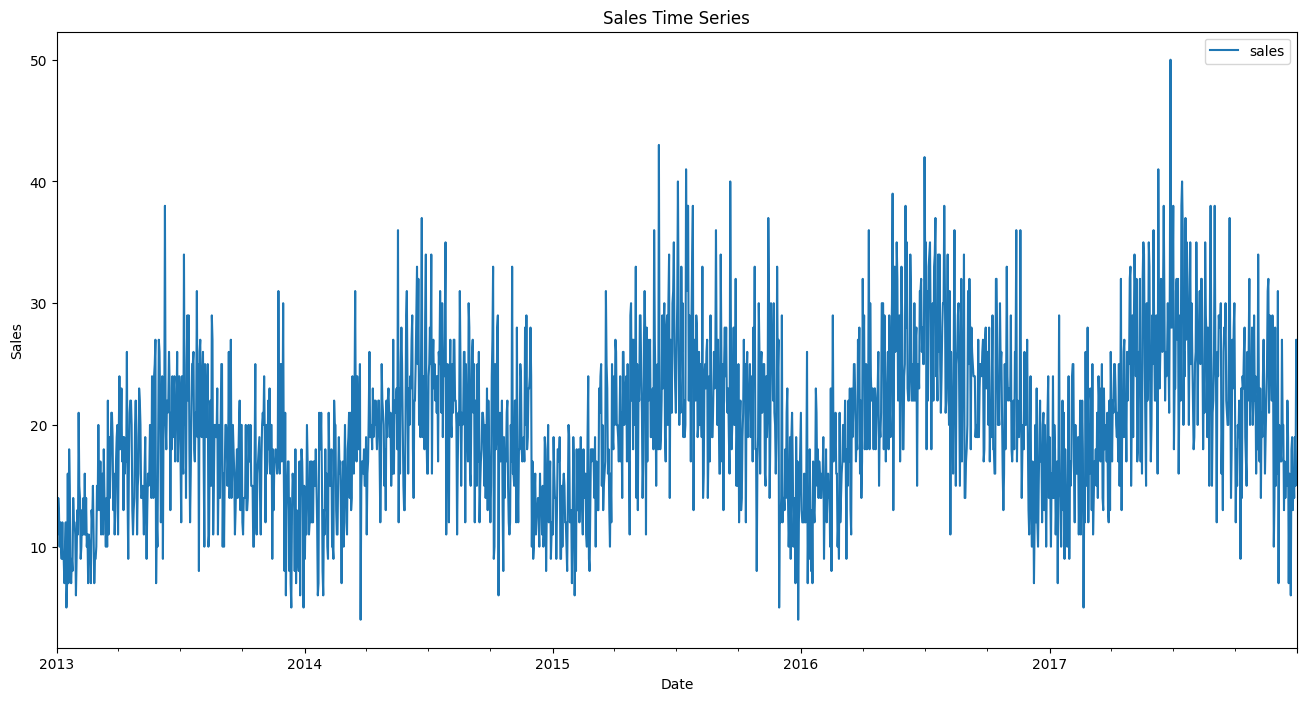

In [16]:
# Plot sales as a time series
data.plot(figsize=(16, 8))
plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')

In [17]:
# for better visual inspection of trends and seasonality let create a smoother time series

<Axes: title={'center': 'weekly Rolling Average'}, xlabel='date', ylabel='Sales'>

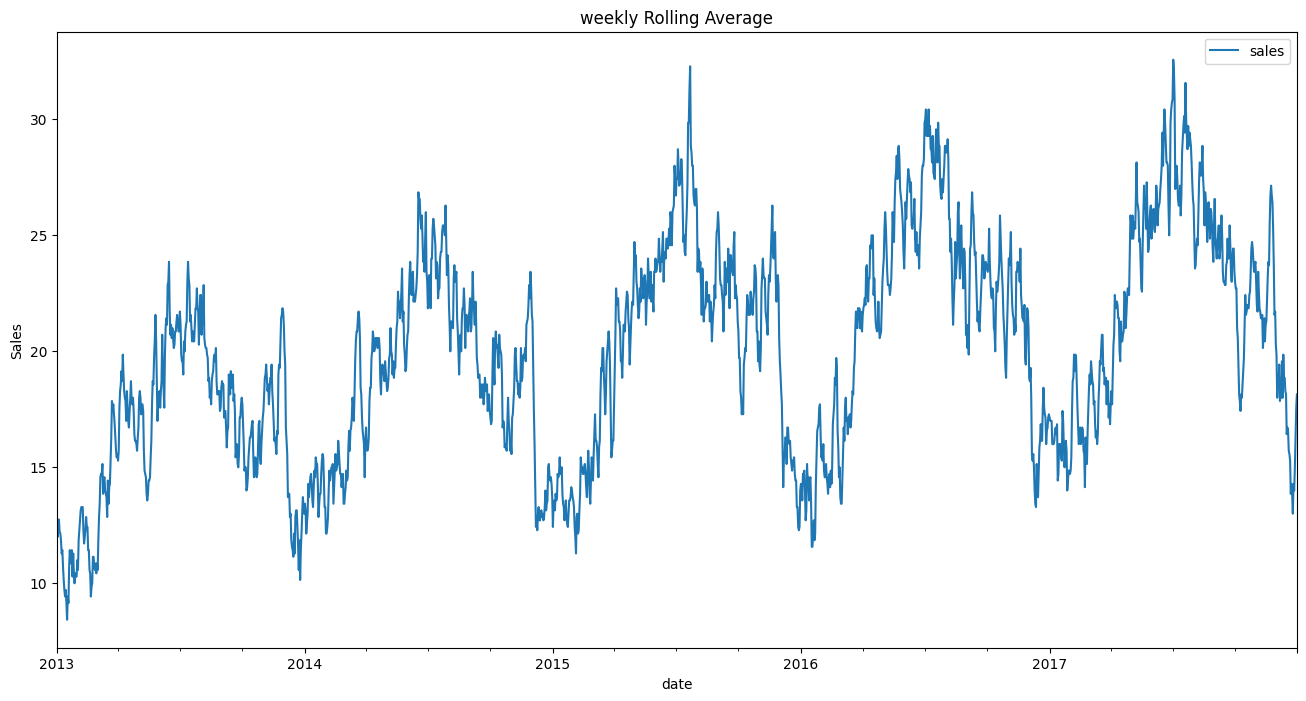

In [18]:
# weekly average 
data.rolling(window='7D').mean().plot(figsize=(16, 8),ylabel="Sales",title="weekly Rolling Average")

<Axes: title={'center': 'monthly Rolling Average'}, xlabel='date', ylabel='Sales'>

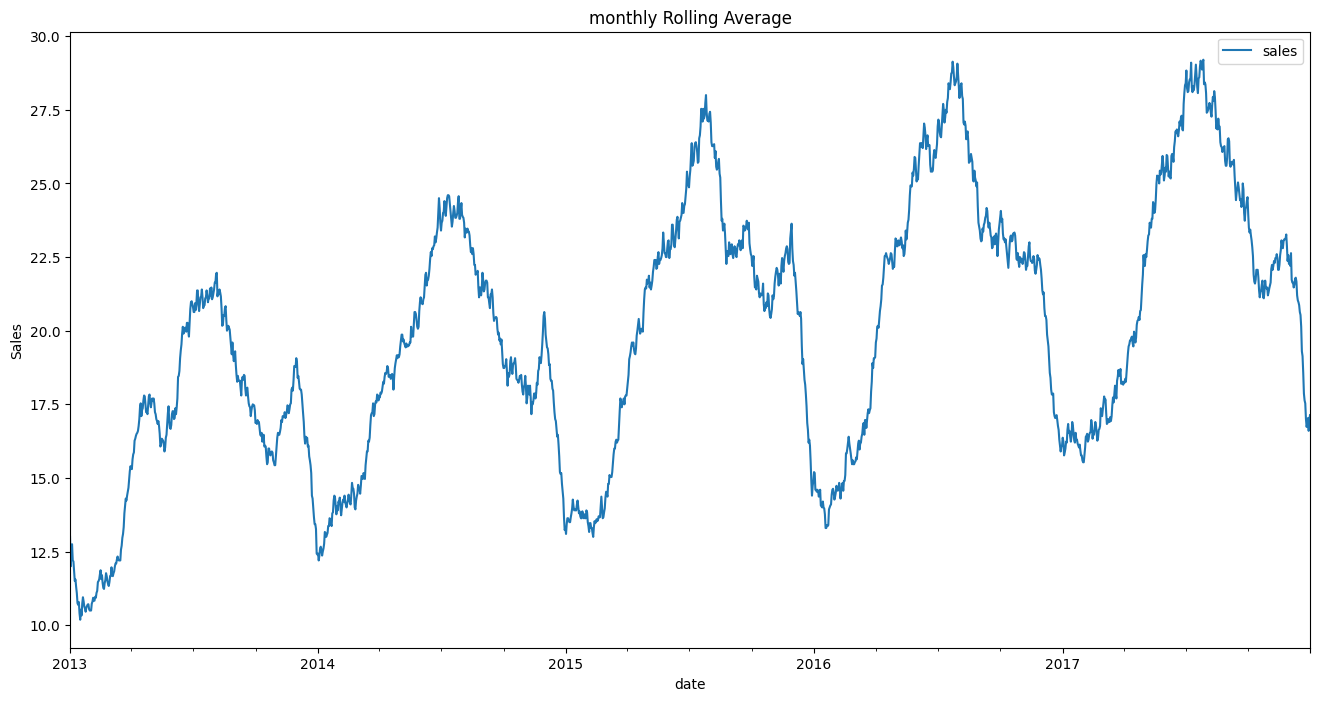

In [19]:
# monthly average 
data.rolling(window='30D').mean().plot(figsize=(16, 8),ylabel="Sales",title="monthly Rolling Average")

In [20]:
# therer appear to be ouliers lets analyze them further
Q1 = data['sales'].quantile(0.25)
Q3 = data['sales'].quantile(0.75)

# IQR (Interquartile Range)
IQR = Q3 - Q1

# bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# identify outliers
outliers = data[(data['sales'] < lower_bound) | (data['sales'] > upper_bound)]


In [21]:
outliers

,sales
date,
2013-06-09,38
2015-06-06,43
2015-07-04,40
2015-07-16,41
2015-07-18,38
2015-07-19,38
2015-07-26,38
2015-09-19,40
2016-05-15,39


In [22]:
# replace outliers with rolling mean of last 3 non-outlier values
outliers = (data['sales'] < lower_bound) | (data['sales'] > upper_bound)

rolling_mean = data['sales'].where(~outliers).rolling(window=3, min_periods=1).mean()
data.loc[:,'sales']= data['sales'].astype('float')


data.loc[outliers, 'sales'] = rolling_mean[outliers]

/tmp/ipykernel_26/2514429031.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[20.5 21.5 28.  19.5 31.  31.  31.5 17.5 28.  24.5 25.  30.  21.  28.5
 26.5 29.5 25.5 22.  22.5 24. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[outliers, 'sales'] = rolling_mean[outliers]


In [23]:
data.describe()

,sales
count,1826.000000
mean,19.814622
std,6.447597
min,4.000000
25%,15.000000
50%,19.000000
75%,24.000000
max,37.000000


Text(0, 0.5, 'Sales')

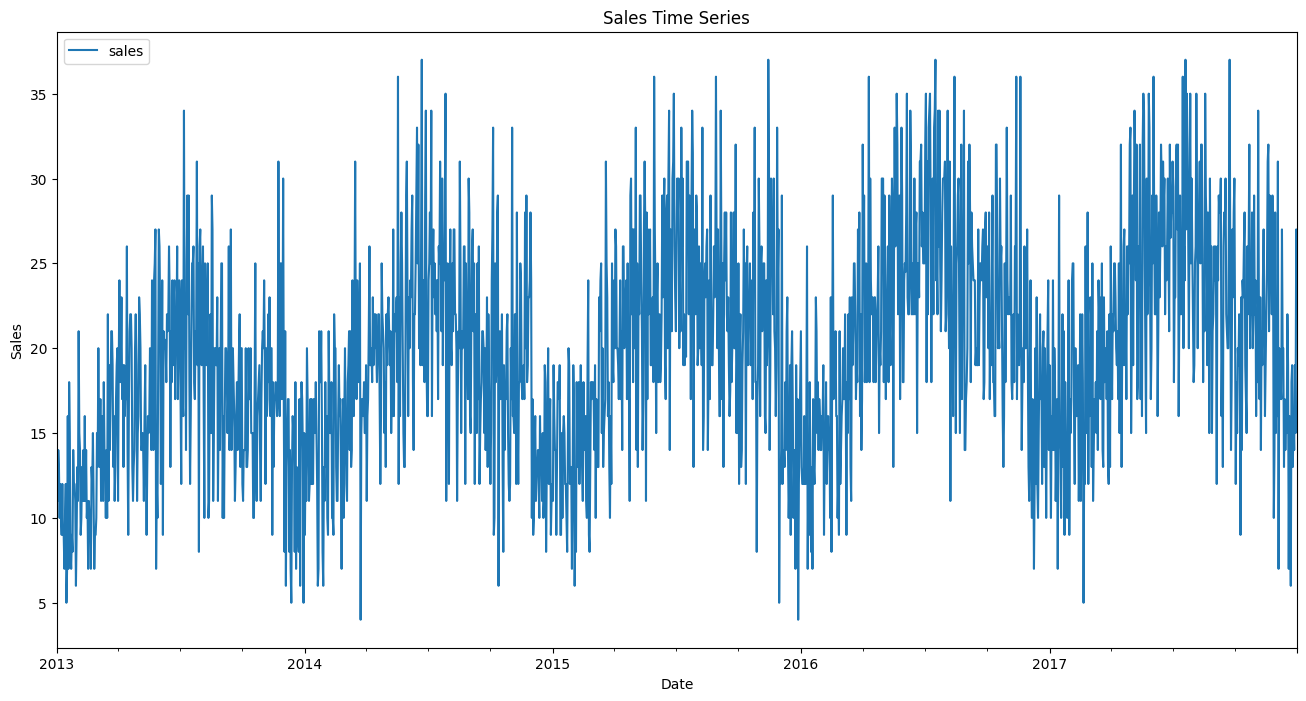

In [24]:
# Plot sales as a time series
data.plot(figsize=(16, 8))
plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')

In [25]:
# we can identify that there is some trend and seasonality in the data

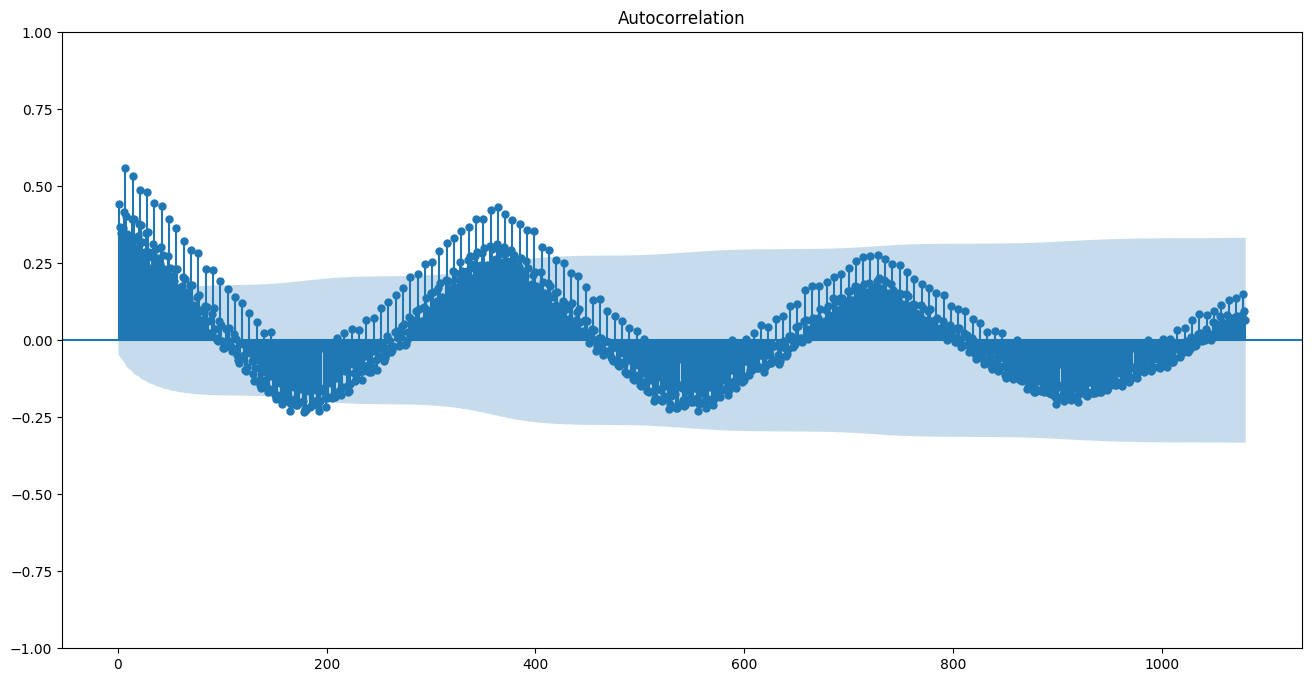

In [26]:
# lets decompose the time series
# lets examine the pcf to identify seasonality period
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_acf(data, ax =ax, lags = 1080, zero=False)

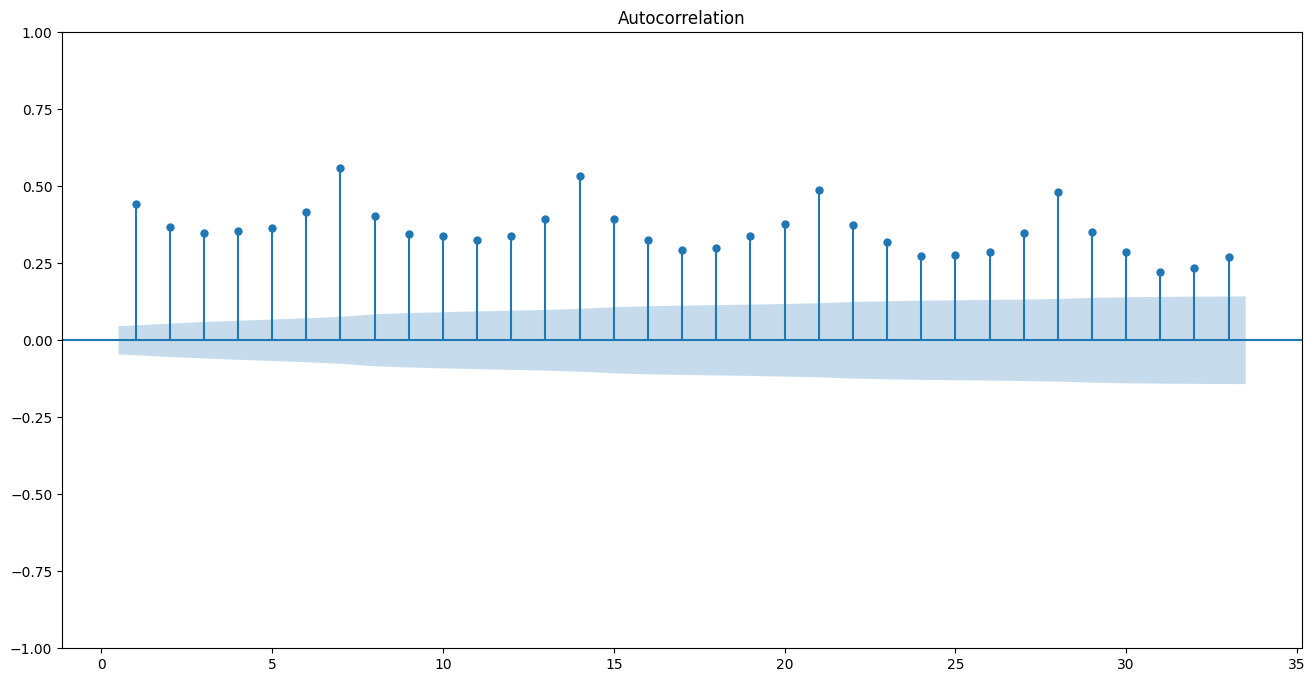

In [27]:
# there appears to be multiple periods of seasonality
# lets focus on earlier lags
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_acf(data, ax =ax, zero=False)

In [28]:
# there appears to be weekly seasonality
# because of the wave form of the pacf lets seasonality at much later lags

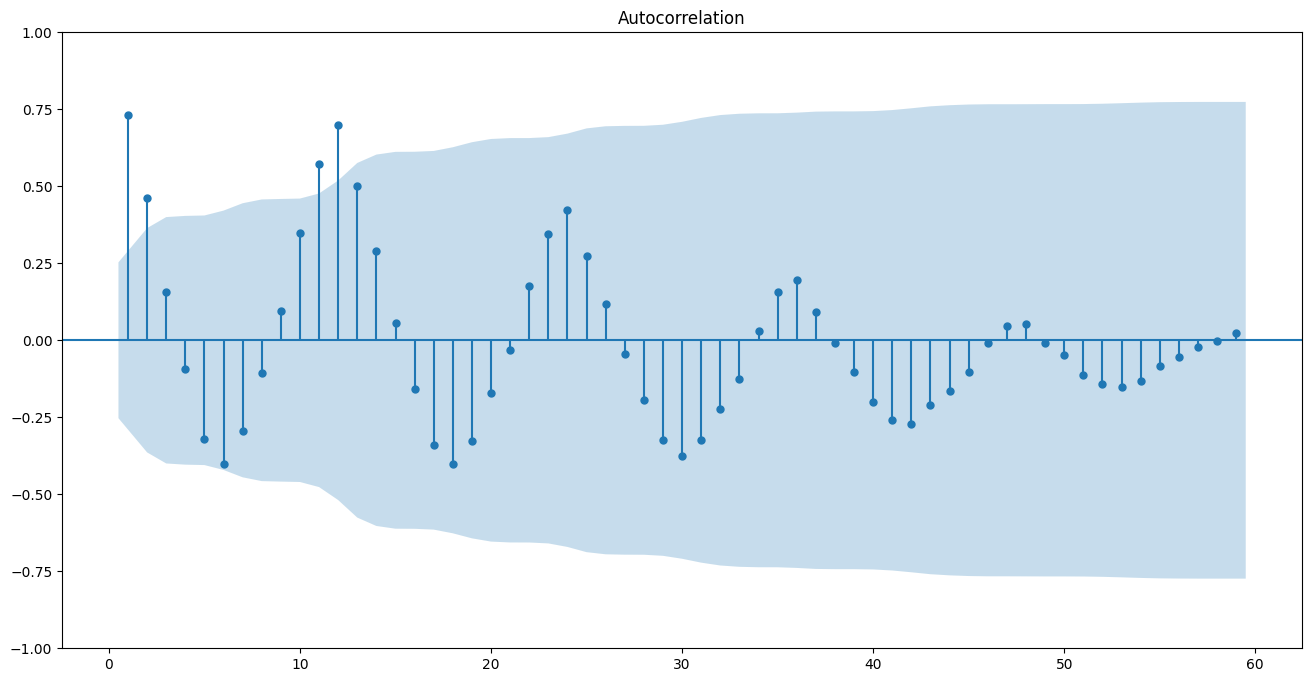

In [29]:
fig,ax=plt.subplots(1,1,figsize=(16, 8))
# because of the high granularity of the data it might be difficult to identify the period directly
# resample at monthly granularity to understand seasonality better
plt.close(fig) 
plot_acf(data.resample('ME').mean() , ax =ax, lags=59, zero=False)

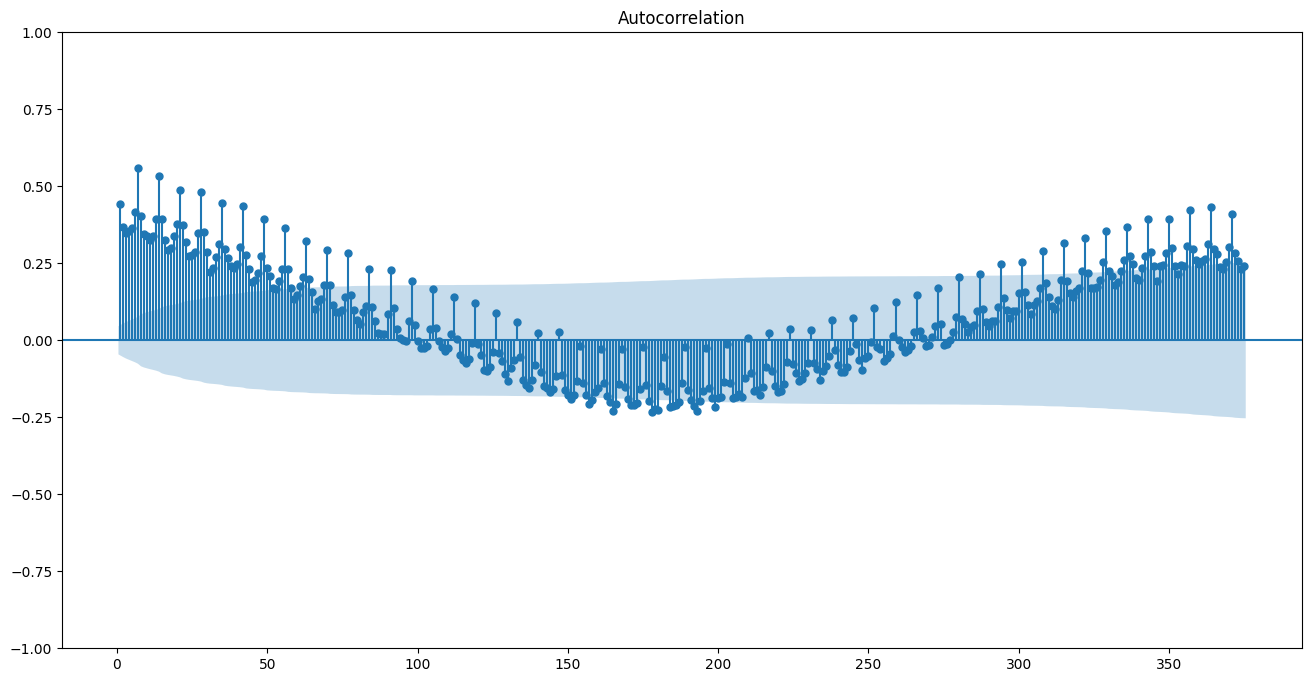

In [30]:
# since 12 was the seasonality period (highest pcf apart from 1) at monthly level this points to a yearly seasonality
# investigate further at daily granularity  
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_acf(data, ax =ax, lags=375, zero=False)

In [31]:
# we can observe that the peak values weekly and yearly
# another interesting pattern is the significant negative correlation occuring around the middle of the year

In [32]:

# lets decompose the weekly seasonality
decomp_results = seasonal_decompose(data, period=7)

<Axes: title={'center': 'Residual'}, xlabel='date'>

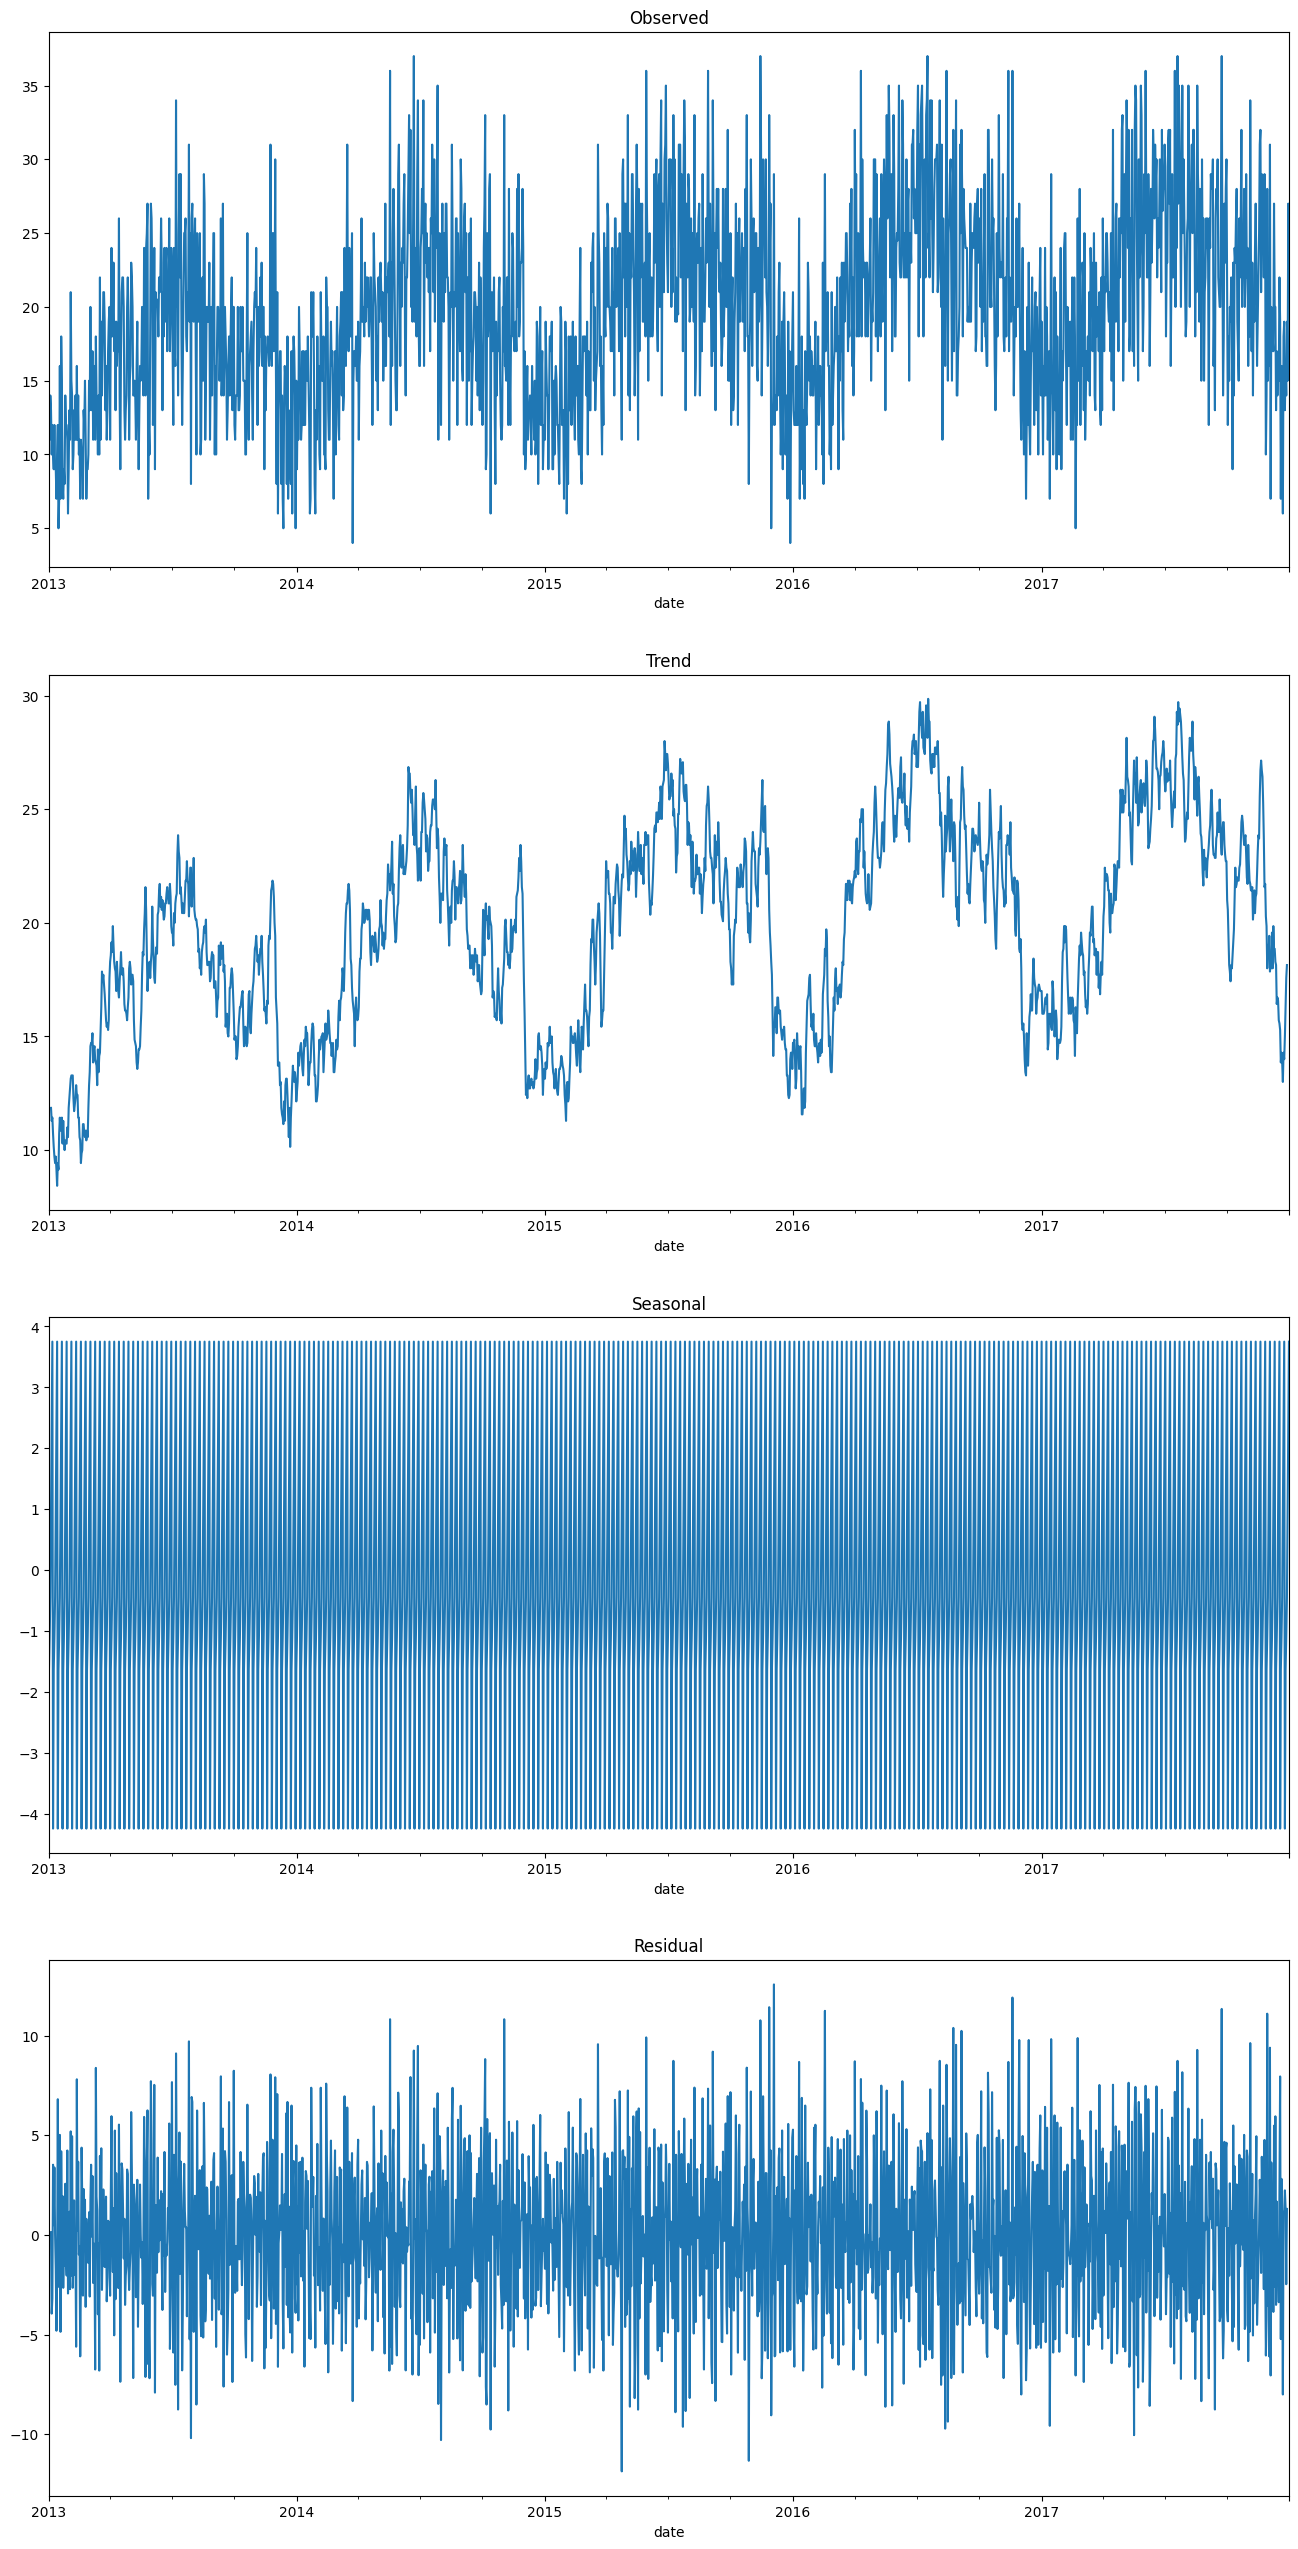

In [33]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 32))

decomp_results.observed.plot(ax=ax1, title='Observed')
decomp_results.trend.plot(ax=ax2, title='Trend')
decomp_results.seasonal.plot(ax=ax3, title='Seasonal')
decomp_results.resid.plot(ax=ax4, title='Residual')

In [34]:
# from the decomposition it appears that the time series is not stationary
# for further statisitcal analysis lets apply the adfuller test
results = adfuller(data, regression='ct')

In [35]:
# check p value
results[1]

0.1250564613713172

Text(0, 0.5, 'Sales')

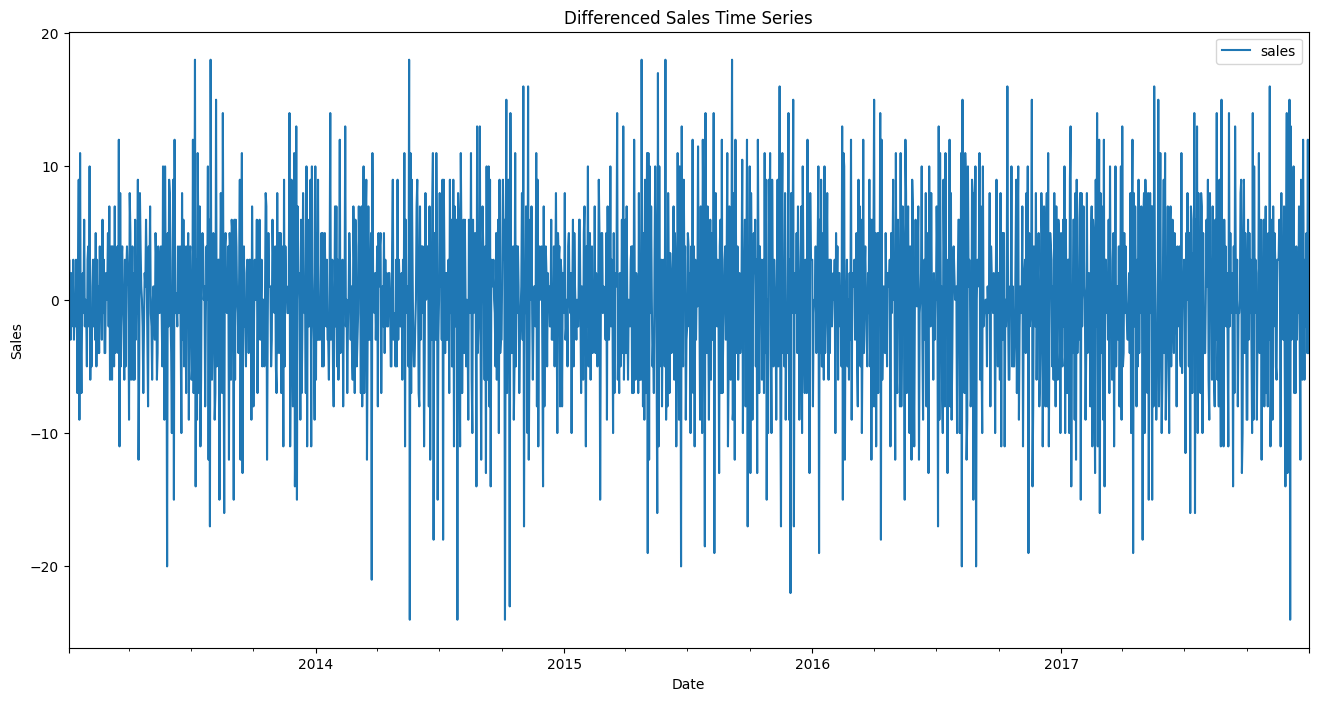

In [36]:
# since p value > 0.05 we accept the null hypothesis of non-stationarity
# due to the seasonal nature of the data we would use the SARIMA model for forecasting
#since the data is non stationary and seasonal we need to apply differencing to removes seasonality and make stationary
#eliminate trend by taking first difference
data_diff=data.diff().dropna()
data_diff.plot(figsize=(16, 8))
plt.title('Differenced Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')

In [37]:
# lets check for stationarity due to trend
# lets use the adfuller test
results = adfuller(data_diff, regression='c')

In [38]:
results[1]

2.413090863543551e-28

In [39]:
# the time series is stationary due to trend

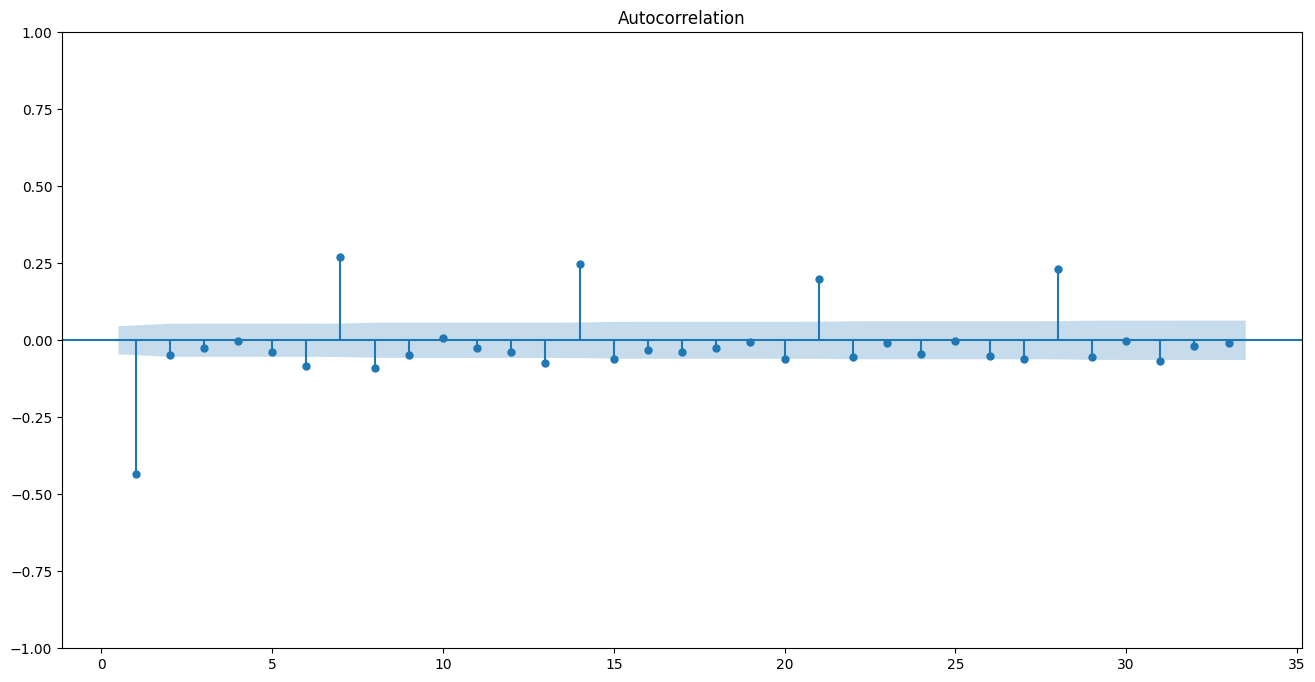

In [40]:
# use acf to check if there is seasonality
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_acf(data_diff , ax =ax, zero=False)

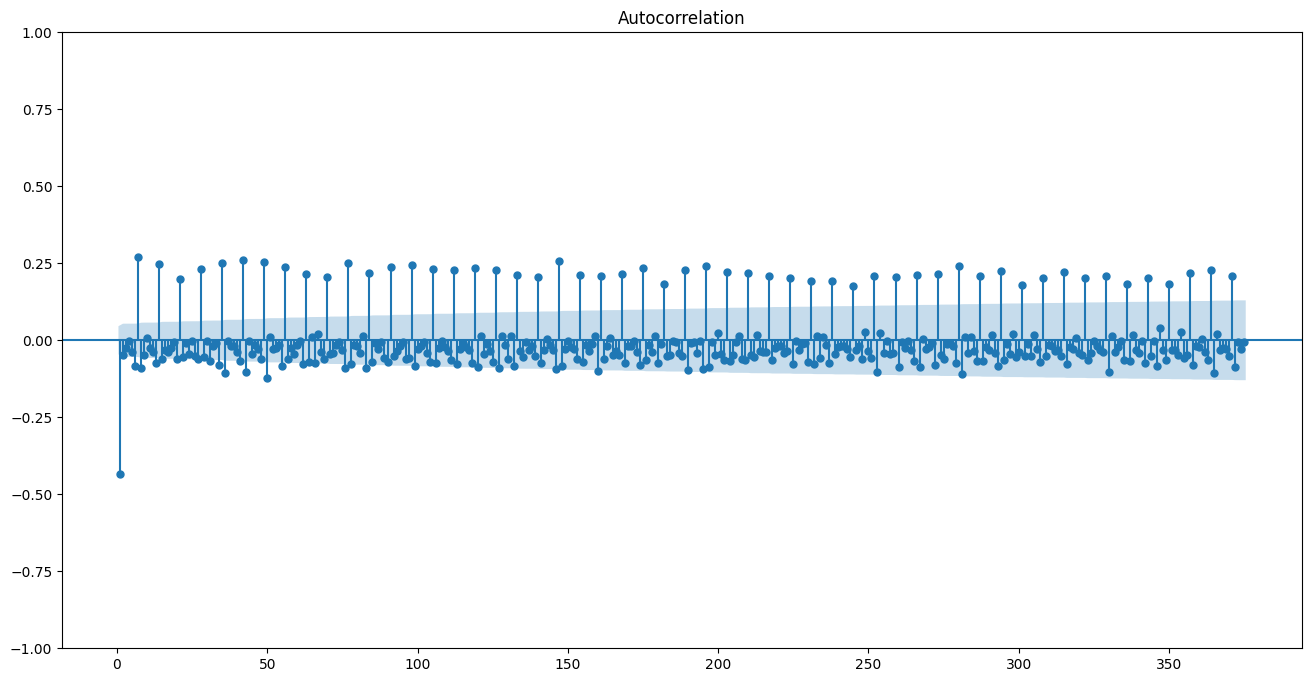

In [41]:
# use acf to check if there is seasonality
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_acf(data_diff , ax =ax, lags=375, zero=False)

Text(0, 0.5, 'Sales')

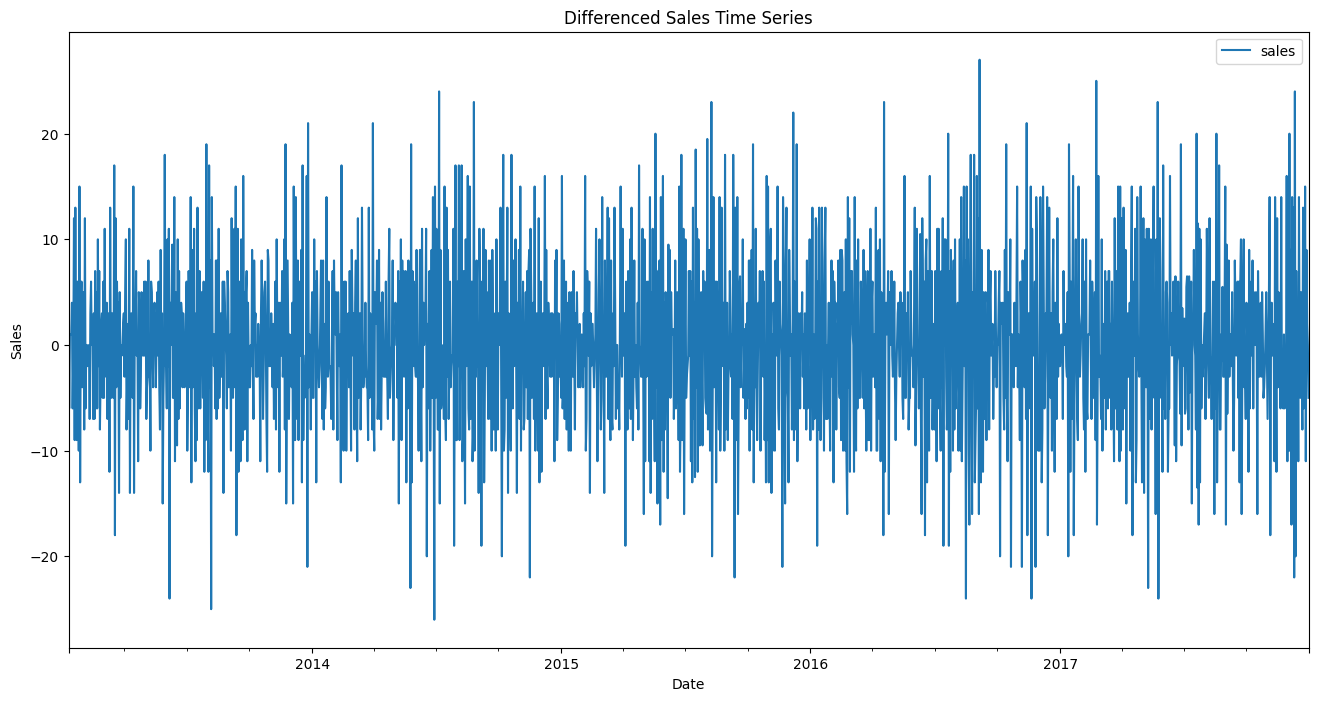

In [42]:
# the trend seems to be eliminated 
# take seasonal difference to remove seasonality 
data_seasonal_diff=data_diff.diff(7).dropna()
data_seasonal_diff.plot(figsize=(16, 8))
plt.title('Differenced Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')

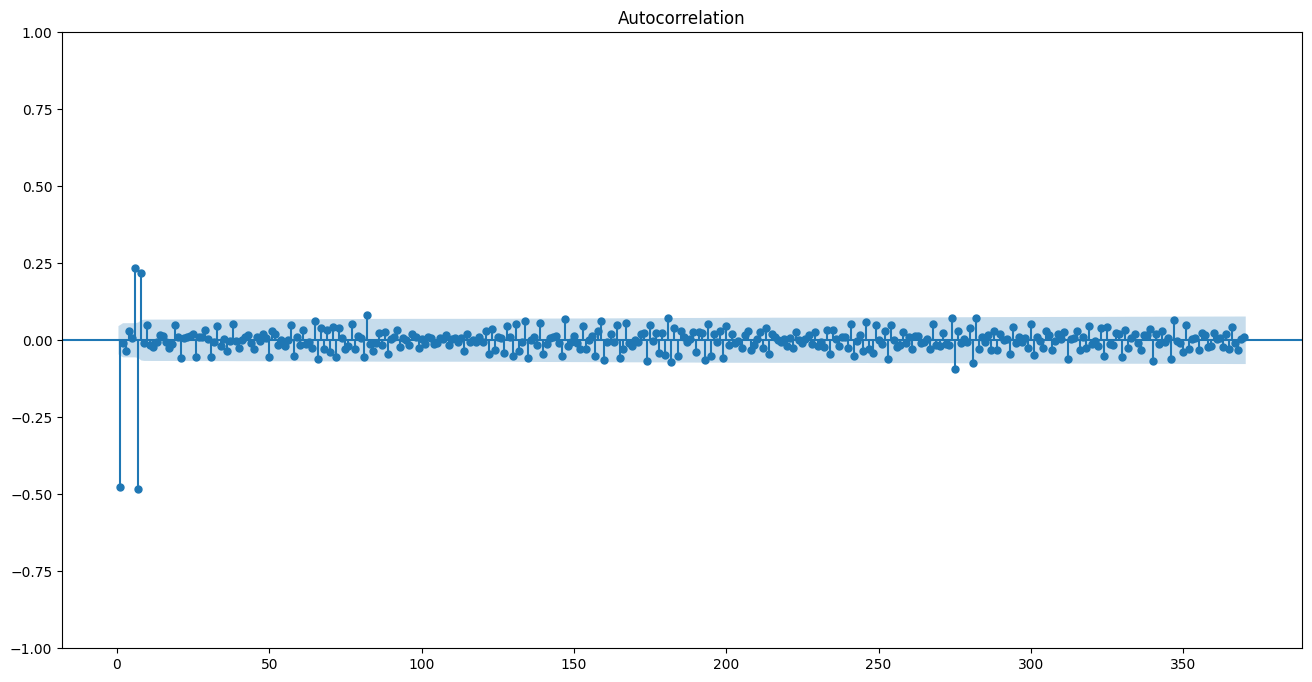

In [43]:
# use acf to check if there is seasonality
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_acf(data_seasonal_diff , ax =ax, lags=370, zero=False)

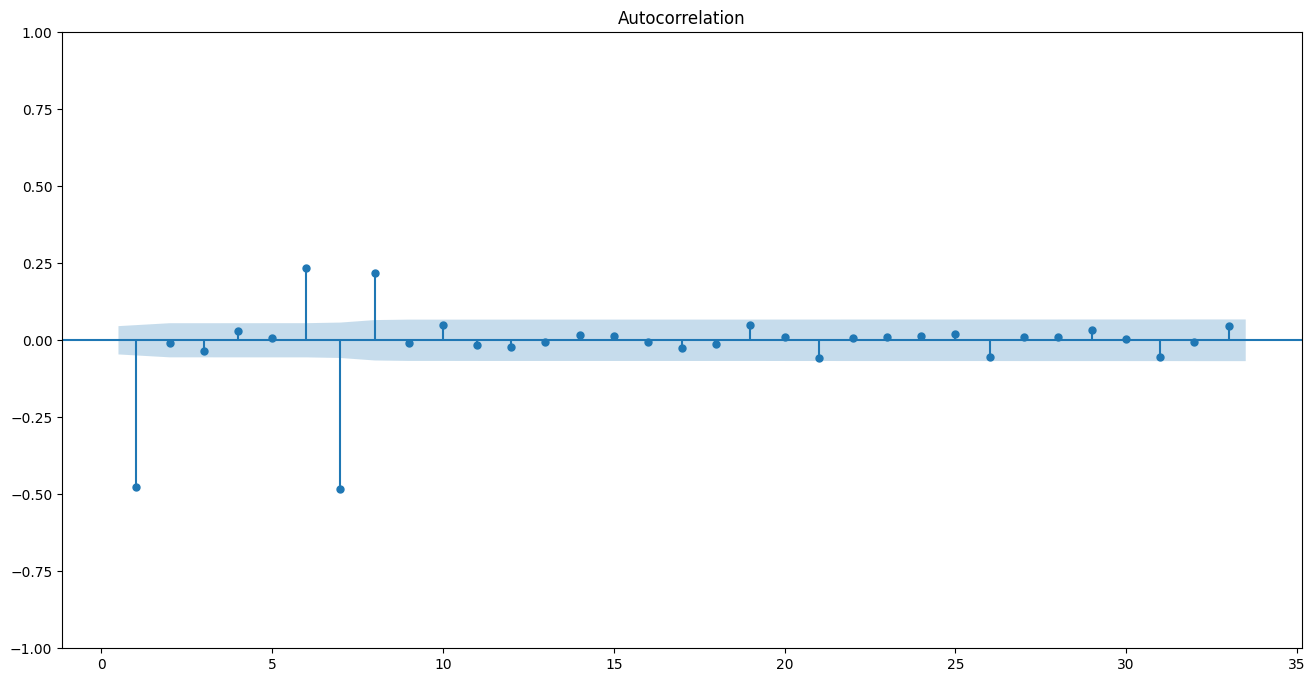

In [44]:
# use acf to check if there is seasonality
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_acf(data_seasonal_diff , ax =ax, zero=False)

In [45]:
# since we are dealing with seasonality we would apply a sarima model
# lets pick model parameters (p,d,q) and (P,D,Q)

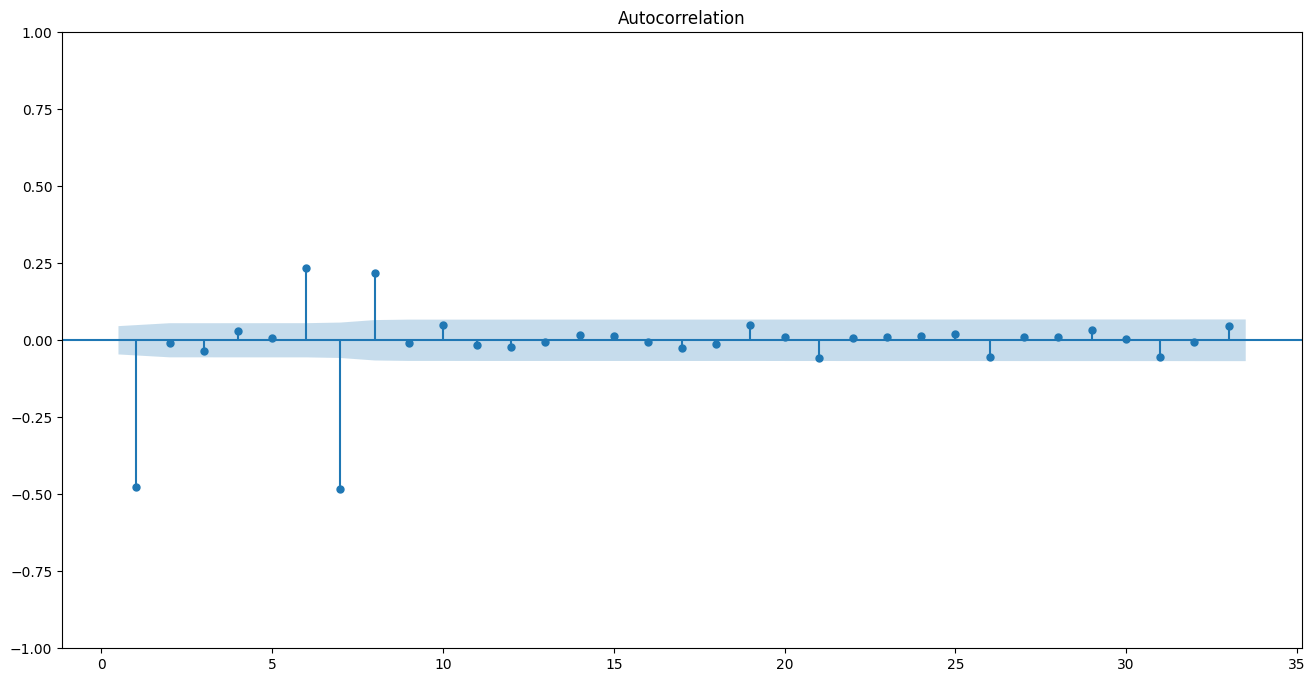

In [46]:
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_acf(data_seasonal_diff , ax =ax, zero=False)

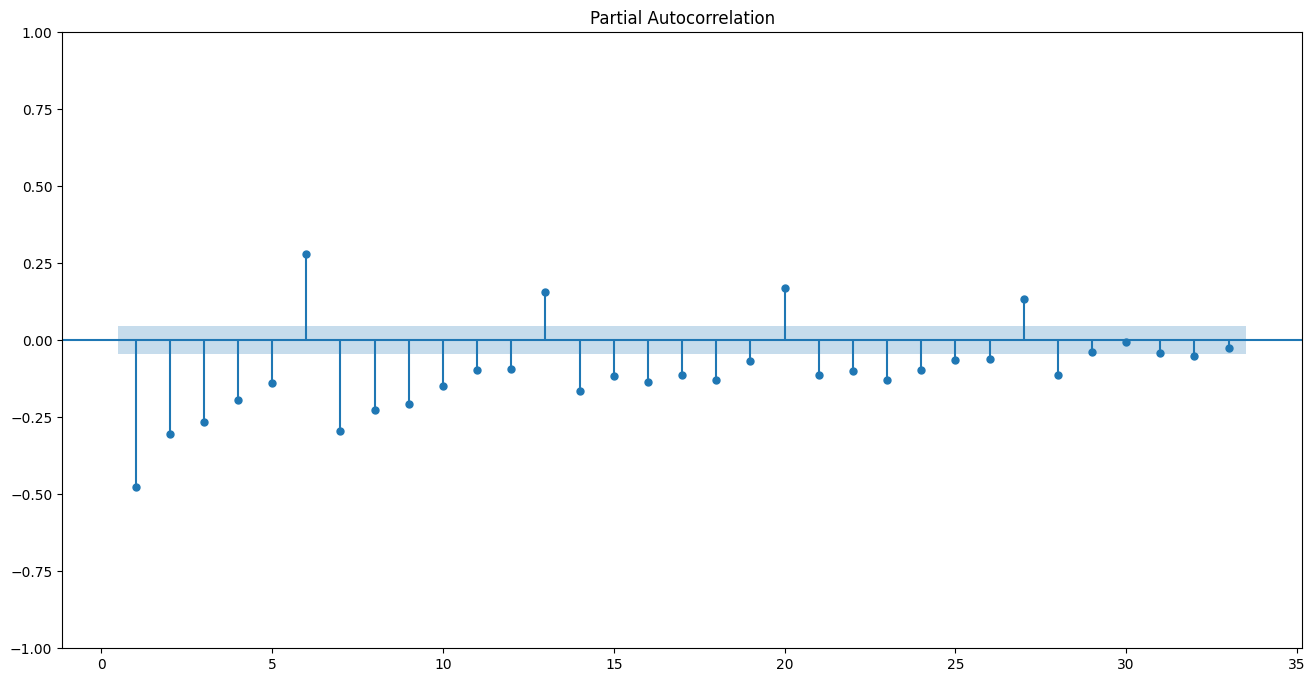

In [47]:
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_pacf(data_seasonal_diff , ax =ax, zero=False)

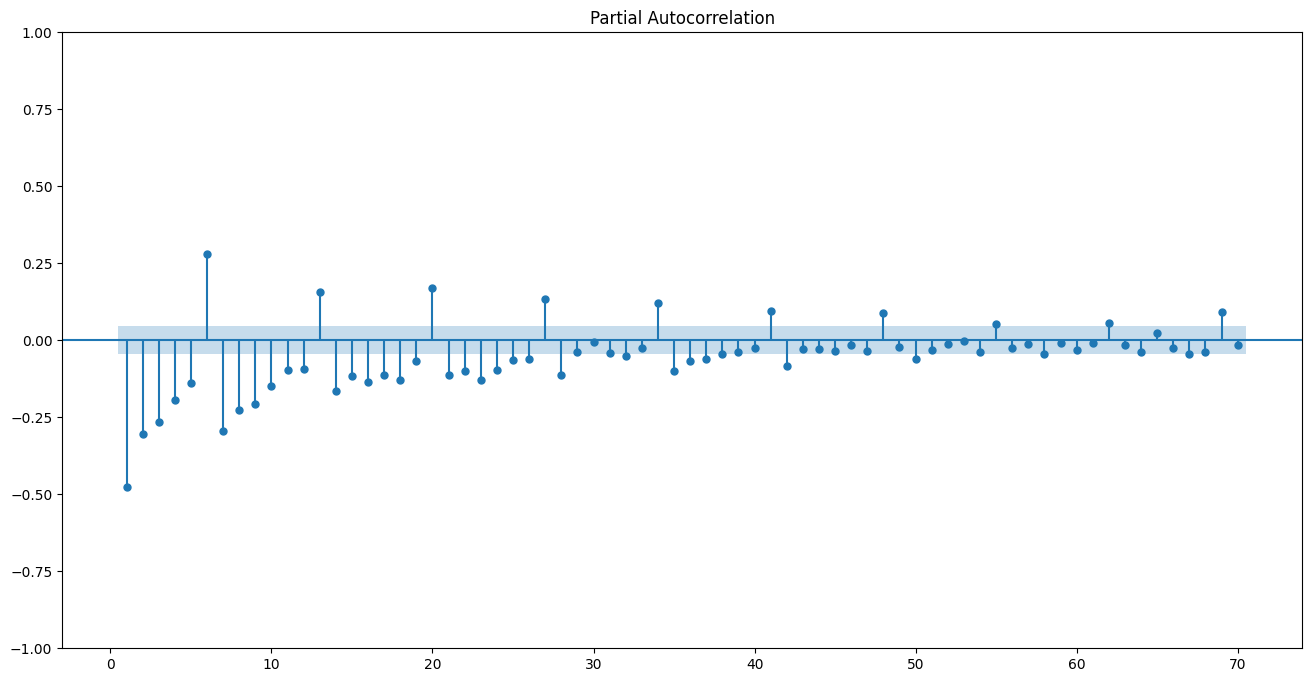

In [48]:
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_pacf(data_seasonal_diff , lags = 70, ax =ax, zero=False)

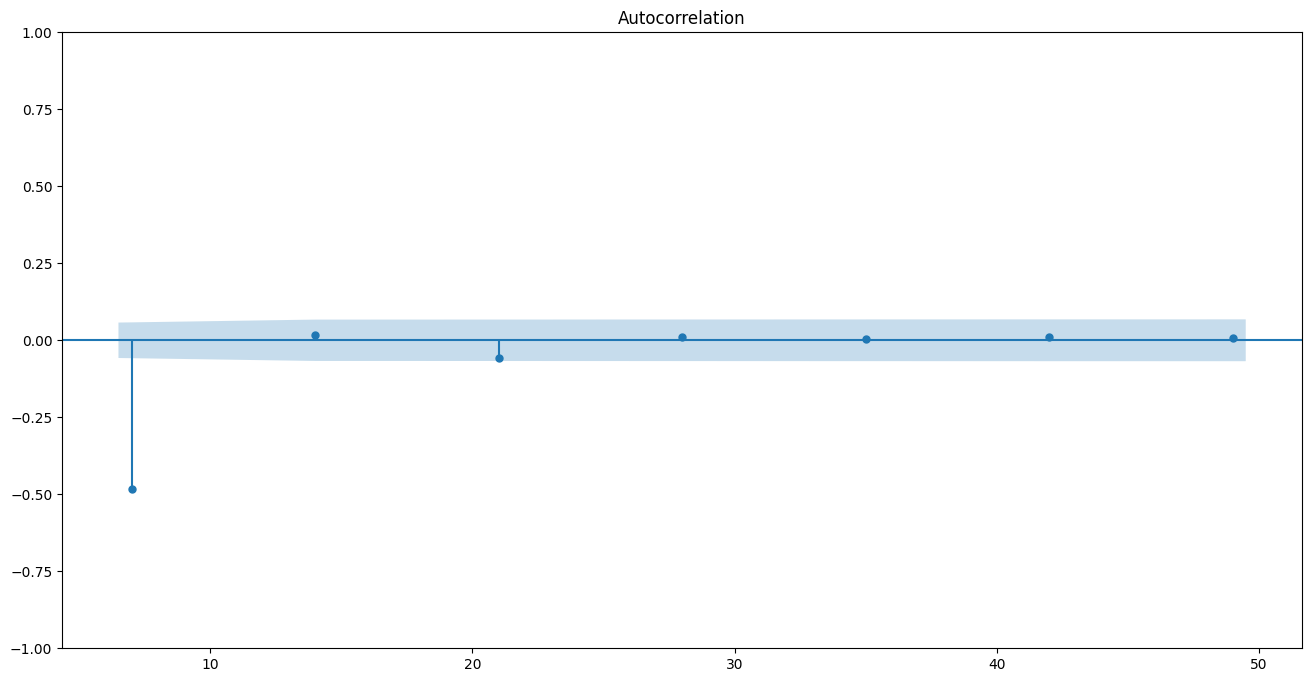

In [49]:
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_acf(data_seasonal_diff , lags =[7,14,21,28,35,42,49], ax =ax, zero=False)

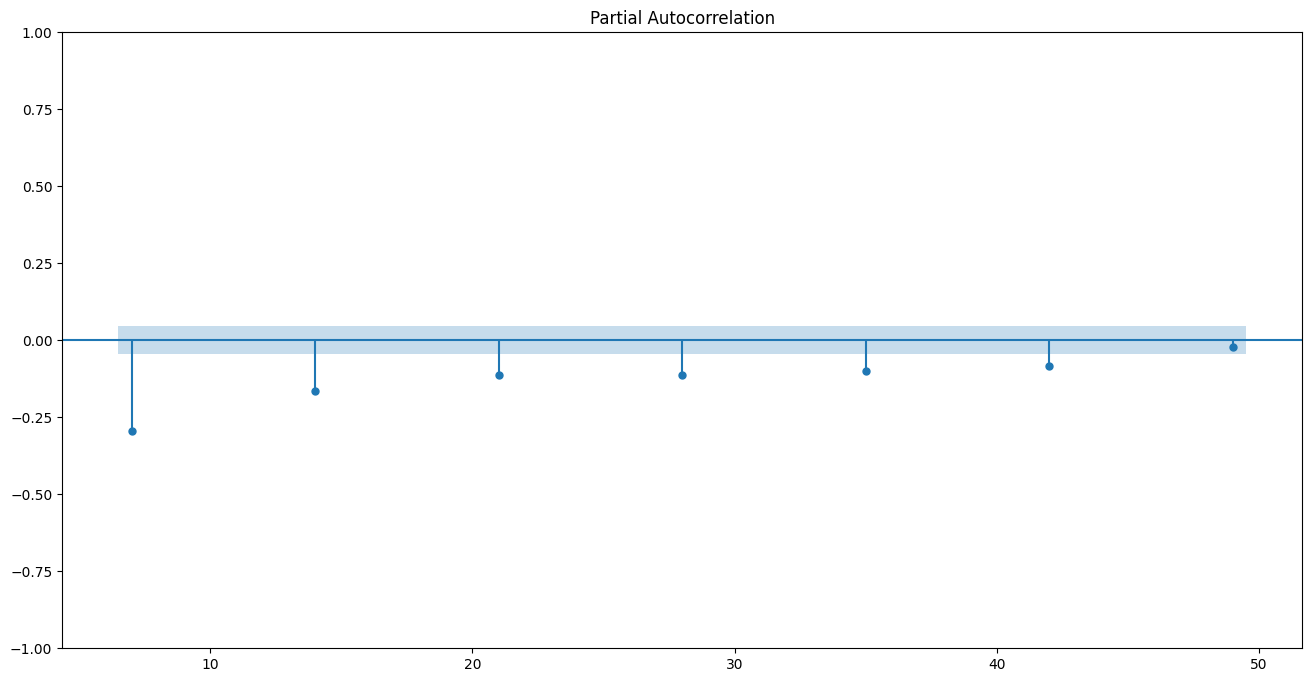

In [50]:
fig,ax=plt.subplots(1,1,figsize=(16, 8))
plt.close(fig) 
plot_pacf(data_seasonal_diff , lags =[7,14,21,28,35,42,49], ax =ax, zero=False)

In [51]:
# from the plots above potential parameters are

p =0;
q= 6 or 8;
P = 0;
Q = 1

In [52]:
# lets create relevant exogenous variable

In [53]:
data['month'] = data.index.month
data['day_of_week'] = data.index.dayofweek
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data['first_year_lag'] = data.sales.shift(365)
data['mid_year_lag'] = data.sales.shift(182)

In [54]:
data=data.dropna()

In [55]:
data.head()

,sales,month,day_of_week,is_weekend,first_year_lag,mid_year_lag
date,,,,,,
2014-01-01,9.0,1,2,0,13.0,12.0
2014-01-02,14.0,1,3,0,11.0,24.0
2014-01-03,11.0,1,4,0,14.0,17.0
2014-01-04,20.0,1,5,1,13.0,16.0
2014-01-05,17.0,1,6,1,10.0,34.0


In [56]:
data.groupby('month')['sales'].mean()

month
1     14.491935
2     15.407080
3     18.153226
4     21.633333
5     23.435484
6     25.083333
7     26.177419
8     23.245968
9     22.104167
10    20.653226
11    21.941667
12    15.306452
Name: sales, dtype: float64

In [57]:
data.groupby('day_of_week')['sales'].mean()

day_of_week
0    16.163462
1    19.014423
2    19.452153
3    20.246411
4    21.617225
5    23.380383
6    24.667464
Name: sales, dtype: float64

In [58]:
data.groupby('is_weekend')['sales'].mean()

is_weekend
0    19.302013
1    24.023923
Name: sales, dtype: float64

In [59]:
data.index.min(),data.index.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [60]:

cal = calendar()
holidays = cal.holidays(start=data.index.min(), end=data.index.max())

# Create a new column 'holiday' that checks if the date is in the holidays list
data.loc[:, 'holiday'] = data.index.isin(holidays).astype(int)


/tmp/ipykernel_26/1287721201.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'holiday'] = data.index.isin(holidays).astype(int)


In [61]:
data.head()

,sales,month,day_of_week,is_weekend,first_year_lag,mid_year_lag,holiday
date,,,,,,,
2014-01-01,9.0,1,2,0,13.0,12.0,1
2014-01-02,14.0,1,3,0,11.0,24.0,0
2014-01-03,11.0,1,4,0,14.0,17.0,0
2014-01-04,20.0,1,5,1,13.0,16.0,0
2014-01-05,17.0,1,6,1,10.0,34.0,0


In [62]:
data.groupby('holiday')['sales'].mean()

holiday
0    20.767065
1    16.600000
Name: sales, dtype: float64

In [63]:
data_with_dummies = pd.get_dummies(data, columns=['month', 'day_of_week'], drop_first=True)

In [64]:
data_with_dummies.head()

,sales,is_weekend,first_year_lag,mid_year_lag,holiday,month_2,month_3,month_4,month_5,month_6,...,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,9.0,0,13.0,12.0,1,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2014-01-02,14.0,0,11.0,24.0,0,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2014-01-03,11.0,0,14.0,17.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2014-01-04,20.0,1,13.0,16.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2014-01-05,17.0,1,10.0,34.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [65]:
# convert the boolean columns to integers
for col in data_with_dummies.columns[5:]:
    data_with_dummies[col] = data_with_dummies[col].astype(int)

In [66]:
data_with_dummies.head()

,sales,is_weekend,first_year_lag,mid_year_lag,holiday,month_2,month_3,month_4,month_5,month_6,...,month_9,month_10,month_11,month_12,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,9.0,0,13.0,12.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2014-01-02,14.0,0,11.0,24.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2014-01-03,11.0,0,14.0,17.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2014-01-04,20.0,1,13.0,16.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2014-01-05,17.0,1,10.0,34.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [67]:
# lets split the data for cross validation
cutoff = int(len(data_with_dummies) * 0.80) # a high percent is choosen due to computation expense
data_train=data_with_dummies.iloc[:cutoff]
data_cv = data_with_dummies.iloc[cutoff:]

In [68]:
exo_train = data_train.drop(columns=['sales'])

In [69]:
exo_cv=data_cv.drop(columns=['sales'])

In [70]:
y_train = data_train['sales']
y_cv = data_cv['sales']

In [71]:
y_train=y_train.asfreq('D')

In [72]:
y_cv=y_cv.asfreq('D')

## Model selection

## Step 1
Do an automatic parameter search using auto_arima


results = pm.auto_arima(
    y_train,
    d=1,
    start_p=0,
    start_q=1,
    max_p=7,
    max_q=8,
    seasonal=True,
    m=7,
    D=1,
    start_P=0,
    start_Q=0,
    max_P=7,
    max_Q=7,
    X=exo_train,
    information_criterion='aic',
    trace=True,
    error_action='ignore',
    stepwise=True
)


# examine model for normality and correlation
plt.rcParams['figure.figsize'] = [12, 8]

results.plot_diagnostics()
plt.show()

print(results.summary())

# the plots and statistical tests indicate normality and no correlation

fitted_values = results.predict_in_sample(X=exo_train)

mean_absolute_error(y_train, fitted_values)

y_train.mean()

# Visualize predicted values vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_train, label="Actual Values", color='blue')


plt.plot(fitted_values, label="Fitted Values (Predictions)", color='red', linestyle='--')


plt.title("Actual vs Fitted Values on Training Set")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()

In [73]:
# create SMMAPE function for evaluation
def smape(y_true, y_pred):
 
    mask = (y_true == 0) & (y_pred == 0)
    
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    smape_values = np.where(mask, 0, numerator / denominator)
    
    smape_value = np.mean(smape_values) * 100
    return smape_value

smape_train1 = smape(y_train, fitted_values)

print(smape_train1)

## Step 2

check if initial guess for parameters might yeild better model

initial guess for model parameters were

        p=0
        q=6
        P=0
        Q=1

In [74]:
model2 = SARIMAX(y_train, 
                 exog=exo_train,
                 order=(0, 1, 6), 
                 seasonal_order=(0, 1, 1, 7))


sarima_result2 = model2.fit()


print(sarima_result2.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.08606D+00    |proj g|=  7.36576D-02


 This problem is unconstrained.



At iterate    5    f=  2.93009D+00    |proj g|=  1.28810D-02

At iterate   10    f=  2.89981D+00    |proj g|=  2.27753D-02

At iterate   15    f=  2.87972D+00    |proj g|=  4.83567D-03

At iterate   20    f=  2.87295D+00    |proj g|=  3.27121D-03

At iterate   25    f=  2.87214D+00    |proj g|=  7.78575D-03

At iterate   30    f=  2.86987D+00    |proj g|=  1.66506D-03

At iterate   35    f=  2.86898D+00    |proj g|=  8.20457D-03

At iterate   40    f=  2.86819D+00    |proj g|=  1.56996D-03

At iterate   45    f=  2.86773D+00    |proj g|=  3.37024D-03

At iterate   50    f=  2.86759D+00    |proj g|=  6.51496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1168
Model:             SARIMAX(0, 1, 6)x(0, 1, [1], 7)   Log Likelihood               -3349.348
Date:                             Sun, 03 Nov 2024   AIC                           6756.695
Time:                                     08:35:52   BIC                           6903.324
Sample:                                 01-01-2014   HQIC                          6812.022
                                      - 03-13-2017                                         
Covariance Type:                               opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
is_weekend     -7.014e-06        nan        nan        nan         nan         nan
first_year_lag 

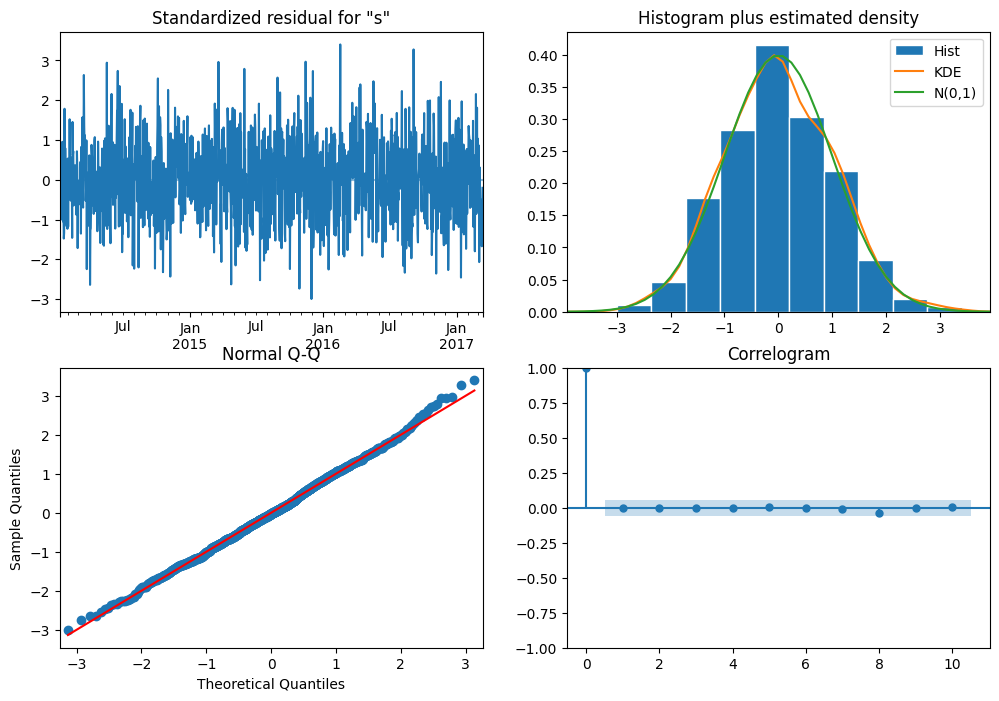

In [75]:
plt.rcParams['figure.figsize'] = [12, 8]  # Adjust as needed

# Call the diagnostics plot
sarima_result2.plot_diagnostics()
plt.show()

In [76]:
# the plots and statistical tests indicate normality and no correlation

In [77]:
fitted_values = sarima_result2.predict()

In [78]:
fitted_values.head()

2014-01-01    -1.350475
2014-01-02     7.996875
2014-01-03    14.545593
2014-01-04    11.110365
2014-01-05    18.489594
Freq: D, Name: predicted_mean, dtype: float64

In [79]:
mean_absolute_error(y_train, fitted_values)

3.47885962120039

In [80]:
y_train.mean()

20.030393835616437

In [81]:
smape_train2 = smape(data_train['sales'], fitted_values)

In [82]:
print(smape_train2)

18.637771572030665


the second model performs better 

lets perform walk forward validation with the test/cv set

to reduce computational expense in this sample project lets limit the walk forward validation to two months

In [83]:
def walk_forward_validation(y_train, y_cv, exo_train, exo_cv, order=(0, 1, 6), seasonal_order=(0, 1, 1, 7)):
    predictions = []

    for i in range (60):
 
        model = SARIMAX(y_train, exog=exo_train, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        
        exog_val = exo_cv.iloc[[i]].values.reshape(1, -1)
        
        # Forecast and store the prediction
        yhat = model_fit.forecast(steps=1, exog=[exog_val])[0]
        predictions.append(yhat)

        # Update history with actual observation and exogenous variable
        y_train=pd.concat([y_train,y_cv.iloc[[i]]])
        exo_train=pd.concat([exo_train,exo_cv.iloc[[i]]])

    return predictions

# Example usage
predictions = walk_forward_validation(y_train, y_cv, exo_train, exo_cv)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_26/3253444261.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = model_fit.forecast(steps=1, exog=[exog_val])[0]
/opt/conda/lib/python3.10/site-packages/statsmode

In [84]:
mean_absolute_error(y_cv[:60], predictions)

3.8364620331659487

In [85]:
y_cv[:60].mean()

21.783333333333335

In [86]:
smape_cv = smape(y_cv[:60], predictions)

In [87]:
print(smape_cv)

18.010773686299768


## Model performance evaluation

The model recorded an SMAPE of 18%.

This is acceeptable as it is below the industry standard of 20%.